In [1]:
"""
author: Henry Piehl
date: 2013-03-01

numerical approximation of the rayleigh-plesset equation
"""

import os,sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# vector function
def f(nu,S,rho_L,p_b,p_infty,z):
    f_ = np.matrix([[z[1,0]], [-4.0*nu*(1.0/z[0,0]**2)*z[1,0] - \
                                (3.0/2.0)*(1.0/z[0,0])*z[1,0]**2 - \
                                (2.0*S/rho_L)*(1.0/z[0,0]**2) + \
                                (1.0/rho_L)*(p_b-p_infty)*(1.0/z[0,0])] ])
    return f_

# jacobian matrix
def J(nu,S,rhoL,p_b,p_infty,z):
    z1=z[0,0]
    z2=z[1,0]
    J_ = np.matrix([[0.0,1.0], \
                    [-(p_b - p_infty)/(rhoL*z1**2) + \
                                4*S/(rhoL*z1**3) + \
                                8.0*nu*z2/z1**3 + \
                                1.5*z2**2/z1**2, -3.0*z2/z1 - 4.0*nu/z1**2]])
    return J_

# functional matrix
def dF(nu,S,rho_L,p_b,p_infty,dt,theta,z):
    return np.matrix([[1.,0.],[0.,1.]])-dt*(1.0-theta)*J(nu,S,rho_L,p_b,p_infty,z)

# 2x2 inverse    
def inverse2x2(A):
    detA = A[0,0]*A[1,1]-A[0,1]*A[1,0]
    Ainv_ = (1.0/detA)*np.matrix([[A[1,1],-A[0,1]],[-A[1,0],A[0,0]]])
    return Ainv_

# pressure function
def p_fun(t0,t1,t2,p0,p1,t):
    p_=p0
    if t>t0:
        p_ = ((1.0 - 1.0 * (1.0/(t2-t1)) * \
             (t1*np.exp(-(t-t0)/t1)-t2*np.exp(-(t-t0)/t2)))-1.0)*(-p0+p1)+p0
    return p_

In [8]:
def main():
    sigma = 0.07
    kappa  = 1.4
    rho_L = 998.8   # fluid density
    nu = 1.09e-6    # fluid viscosity
    theta = 0.5     # weight coefficient for theta-scheme, 0.5 -> Crank-Nicolson
    U_infty = 20.0  # fluid velocity

    tol = 1e-6      # approximation tolerance
    maxIter = 20    # maximal inner iteration 
    pv=2300         # [Pa]; vapor pressure
    p_inf = 1e5     # [Pa]; far field fluid pressure
    p1 = 0.01*p_inf # [Pa]; relative pressure drop

    tStart = 0.0    # start time 
    tEnd =  0.01    # end time
    dt = 0.5e-5     # time step size
    initDT = dt
    t0 = 0.0005     # time for sudden pressure drop
    t1 = 0.001+t0   # start time for smooth pressure rise
    t2 = 0.001+t0+t1# end time for smooth pressure rise
    
    R0 = 0.005      # initial bubble radius
    zInit_ = np.matrix([[R0],[0.0]])    # initial state vector [radius; radiusVelo]
    t=tStart
    
    tSteps = []
    tSteps.append(t)
    p = []
    p.append(p_fun(t0,t1,t2,p_inf,p1,t))    # time dependent pressure function
    p_bList = []
    z = [zInit_]
    dtList = []
    steps=0     # time step counter
    while t<tEnd:
        t+=dt   # increase time 
        
#         print("time={:2.5f} \t".format(t), end = '')
        tSteps.append(t)    # append current time to time list

        p.append(p_fun(t0,t1,t2,p_inf,p1,t))
        zInit = z[-1]       # start values for inner iteration
        zOld =  z[-1]
        zNew =  z[-1]

        p_infty = p[-1]+pv
        R = zNew[0,0]
        p_b = (p_inf +2.0*sigma/R0)*(R0/R)**(3*kappa)+pv
        p_bList.append(p_b)

        err=1.0     # initial relative error
        i = 0       # initial inner iteration counter
        steps+=1    # increase time step counter

        # inner iteration loop
        while err > tol and not i>maxIter:
            
            zNew = zOld - inverse2x2(dF(nu,sigma,rho_L,p_b,p_infty,dt,theta,zOld)) * \
                          (zOld-zInit-dt*theta*f(nu,sigma,rho_L,p_b,p_infty,zInit) - \
                          dt*(1.0-theta)*f(nu,sigma,rho_L,p_b,p_infty,zOld))

            # relative error 
            err = np.sqrt(np.sum((np.array(zNew)-np.array(zOld))**2))

            zOld = zNew     # update state vector
            i+=1            # increase inner iteration counter

        # adaptive time step control      
        if err*1.2<tol:
            dt*=1.05    # increase time step 
        elif err/1.05<tol:
            dt*=0.9     # decrease time step 
    
        # limit max time step
        if dt>initDT:
            dt=initDT
#         print(" error={:1.2e}\t dt={:1.2e}\t substeps i={}, total iterations iT={}".format(err,dt,i,steps))

        z.append(zNew)
        
    p=np.array(p)
    p_bArray = np.array(p_bList)
    tSteps = np.array(tSteps)
    r = np.array([iz[0,0] for iz in z])
    dr = np.array([iz[1,0] for iz in z])

    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(121)
    ax1.plot(tSteps*U_infty/R0,p/p_inf,"-k",lw=1,label=r"$\frac{p_\infty}{p_0}$")
    ax1.plot(tSteps*U_infty/R0,r/R0,"-b",lw=2,label=r"$\frac{R}{R_0}$")
    ax1.legend(loc=4)
    ax1.set_ylabel(r"")
    ax1.set_xlabel(r'$tU_\infty / R_0$')

    ax2 = fig.add_subplot(122)
    ax2.plot(tSteps*U_infty/R0,p/p_inf,"-k",lw=1,label=r"$\frac{p_\infty}{p_0}$")
    ax2.plot(tSteps[1:]*U_infty/R0,p_bArray/p_inf,"-b",lw=2,label=r"$\frac{p_b}{p_0}$")
    ax2.set_yscale('log')
    ax2.set_xlabel(r'$tU_\infty / R_0$')    
    ax2.legend(loc=2)
    plt.savefig("solution_RPG.pdf",dpi=200)
    plt.savefig("solution_RPG.png",dpi=200,format='png')
    plt.show()

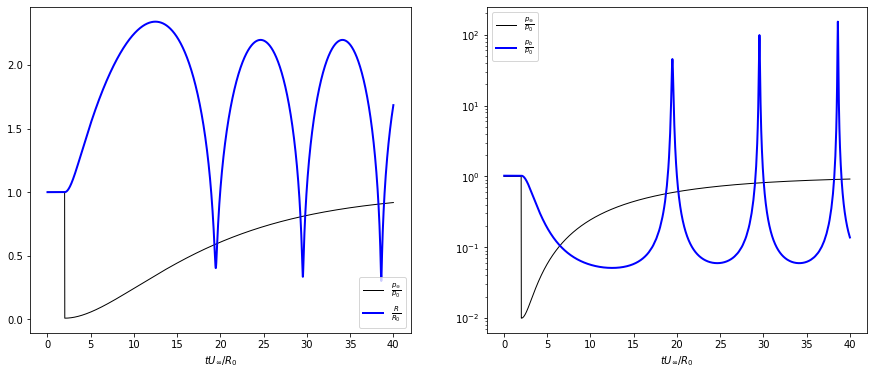

In [9]:
main()